# Air Quality Dataset

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the data
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/AirQualityUCI.xlsx'
air_quality_data = pd.read_excel(file_path)

Mounted at /content/drive


In [3]:
air_quality_data.replace(-200, pd.NA, inplace=True)
numeric_columns = air_quality_data.select_dtypes(include=['number']).columns

## Optimization

In [4]:
# Check for duplicate rows in the dataset
duplicates = air_quality_data.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicates.sum()

# Display whether duplicates exist and how many
if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    #  display the duplicate rows
    print(air_quality_data[duplicates])
else:
    print("No duplicate rows found in the dataset.")


No duplicate rows found in the dataset.


In [5]:
# Impute missing values with the median of each numeric column
for column in numeric_columns:
    median_value = air_quality_data[column].median(skipna=True)
    air_quality_data[column].fillna(median_value, inplace=True)

In [6]:
# Convert 'Date' and 'Time' to datetime and remove original columns
air_quality_data['DateTime'] = pd.to_datetime(air_quality_data['Date'].astype(str) + ' ' + air_quality_data['Time'].astype(str))
air_quality_data.drop(['Date', 'Time'], axis=1, inplace=True)
air_quality_data.dropna(inplace=True)

## Baseline Model Creation

In [7]:
# Define the target variable and the features
X = air_quality_data.drop(['NO2(GT)', 'DateTime'], axis=1)
y = air_quality_data['NO2(GT)']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting values
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluating the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Printing out the performance metrics
print("Baseline Training Data - Mean Squared Error:", train_mse)
print("Baseline Training Data - R^2 Score:", train_r2)
print("Baseline Testing Data - Mean Squared Error:", test_mse)
print("Baseline Testing Data - R^2 Score:", test_r2)

# Calculate and display the baseline R² score
baseline_r2 = (train_r2 + test_r2) / 2
print("Baseline R² Score:", baseline_r2)

Baseline Training Data - Mean Squared Error: 126.09249383052888
Baseline Training Data - R^2 Score: 0.8697218904819313
Baseline Testing Data - Mean Squared Error: 133.17840399888428
Baseline Testing Data - R^2 Score: 0.8767061510322511
Baseline R² Score: 0.8732140207570912


## Applying Stochastic Diffusion Search (SDS)



In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define fitness function for SDS
def sds_evaluate_fitness(X, y, feature_subset):
    if len(feature_subset) == 0:
        return float('-inf')  # Avoid empty feature set
    X_subset = X.iloc[:, feature_subset]
    sds_model = LinearRegression()
    # Using cross-validation to assess model performance
    cv_scores = cross_val_score(sds_model, X_subset, y, cv=5, scoring='r2')
    return np.mean(cv_scores)  # Return the average R² score across folds

# Initialize agents with random subsets of features for SDS
num_agents = 20
num_features = X.shape[1]
sds_agents = [np.random.choice([0, 1], size=num_features, p=[0.5, 0.5]) for _ in range(num_agents)]
sds_best_global_fitness = float('-inf')
sds_best_feature_subset = None

# Iterative search for the best feature subset in SDS
for iteration in range(200):
    for i, agent in enumerate(sds_agents):
        active_features = np.where(agent == 1)[0]
        fitness = sds_evaluate_fitness(X, y, active_features)
        if fitness > sds_best_global_fitness:
            sds_best_global_fitness = fitness
            sds_best_feature_subset = agent.copy()

    # Communicate and update agents in SDS
    for i in range(num_agents):
        if np.random.rand() < 0.3:
            new_agent = np.random.choice([0, 1], size=num_features, p=[0.8, 0.2])
            new_agent[np.where(sds_best_feature_subset == 1)] = 1
            sds_agents[i] = new_agent

# Ensure the number of features does not exceed 20 in the SDS model
if np.sum(sds_best_feature_subset) > 20:
    top_features = np.argsort(sds_best_feature_subset)[-20:]  # Get indices of top 20 features
    sds_best_feature_subset = np.zeros_like(sds_best_feature_subset)
    sds_best_feature_subset[top_features] = 1

# Retrain the final model with the best features from SDS
if sds_best_feature_subset is not None:
    X_best = X.iloc[:, sds_best_feature_subset == 1]
    X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)
    sds_final_model = LinearRegression()
    sds_final_model.fit(X_train, y_train)
    sds_final_train_r2 = r2_score(y_train, sds_final_model.predict(X_train))
    sds_final_test_r2 = r2_score(y_test, sds_final_model.predict(X_test))
    print("SDS Final R^2 with Best Features - Training:", sds_final_train_r2)
    print("SDS Final R^2 with Best Features - Testing:", sds_final_test_r2)
    print("SDS Features Used:", list(X.columns[sds_best_feature_subset == 1]))
    print("SDS Number of Features Used:", np.sum(sds_best_feature_subset))

# Calculate and display the SDS R² score
sds_r2 = (sds_final_train_r2 + sds_final_test_r2) / 2
print("SDS R² Score:", sds_r2)

SDS Final R^2 with Best Features - Training: 0.8659415038841116
SDS Final R^2 with Best Features - Testing: 0.8725713660330463
SDS Features Used: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH']
SDS Number of Features Used: 9
SDS R² Score: 0.869256434958579


## Applying Recursive Feature Elimination (RFE)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score

# Define the feature selection model using Recursive Feature Elimination with Cross-Validation (RFECV)
rfe_model = LinearRegression()
rfe_rfecv = RFECV(estimator=rfe_model, step=1, cv=KFold(5), scoring='r2')
rfe_rfecv.fit(X, y)

# Display the optimal number of features and the best features selected
print("Optimal number of features : %d" % rfe_rfecv.n_features_)
print('Best features:', X.columns[rfe_rfecv.support_])

# Transform the dataset to include only selected features
X_selected = rfe_rfecv.transform(X)
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Fit the model on the reduced dataset and predict
rfe_model.fit(X_train_rfe, y_train_rfe)
rfe_y_pred = rfe_model.predict(X_test_rfe)
rfe_r2 = r2_score(y_test_rfe, rfe_y_pred)

# Print the R^2 score to evaluate the performance of the model with selected features
print("RFE Model R^2 Score with Selected Features:", rfe_r2)


Optimal number of features : 9
Best features: Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S4(NO2)', 'T', 'RH', 'AH'],
      dtype='object')
RFE Model R^2 Score with Selected Features: 0.8732760916504243


## Applying Principal Component Analysis (PCA)

In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Standardizing the features with PCA-specific prefix
pca_scaler = StandardScaler()
X_scaled_pca = pca_scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=0.95)  # Preserve 95% of the variance
X_pca = pca.fit_transform(X_scaled_pca)
print(f"Reduced number of features from {X.shape[1]} to {X_pca.shape[1]} with PCA.")

# Splitting the dataset
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model specific to PCA
pca_model = LinearRegression()
pca_model.fit(X_train_pca, y_train_pca)

# Predicting and evaluating the PCA model
pca_y_pred = pca_model.predict(X_test_pca)
pca_mse = mean_squared_error(y_test_pca, pca_y_pred)
pca_r2 = r2_score(y_test_pca, pca_y_pred)

# Printing out PCA-specific performance metrics
print(f"PCA Model MSE: {pca_mse}")
print(f"PCA Model R^2 Score: {pca_r2}")


Reduced number of features from 12 to 4 with PCA.
PCA Model MSE: 170.33831723867542
PCA Model R^2 Score: 0.8423042615886756


# Applying Filter Method - Mutual Information

Top 10 Features by Mutual Information:
 NOx(GT)          1.039843
CO(GT)           0.955299
PT08.S2(NMHC)    0.865751
C6H6(GT)         0.848971
PT08.S1(CO)      0.770515
PT08.S5(O3)      0.686589
PT08.S4(NO2)     0.619840
NMHC(GT)         0.606144
PT08.S3(NOx)     0.594316
T                0.089468
dtype: float64


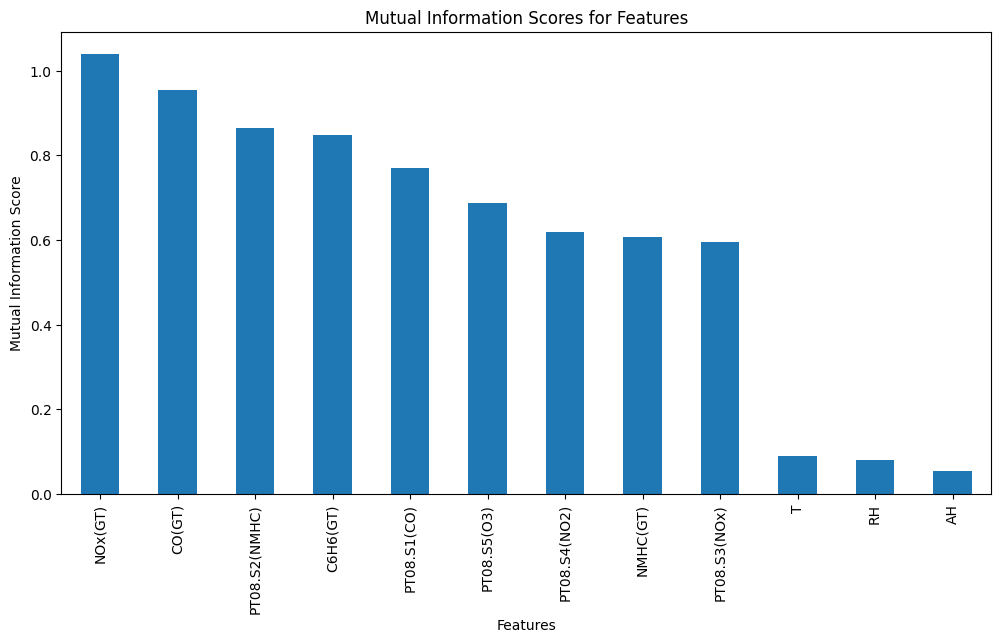


Mutual Information Model - Training Mean Squared Error: 131.258
Mutual Information Model - Training R² Score: 0.864
Mutual Information Model - Testing Mean Squared Error: 138.190
Mutual Information Model - Testing R² Score: 0.872
Mutual Information R² Score: 0.8682255800947729


In [11]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Calculate Mutual Information Scores
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X.columns)

# Rank features by Mutual Information scores
mi_scores_sorted = mi_scores_series.sort_values(ascending=False)
print("Top 10 Features by Mutual Information:\n", mi_scores_sorted.head(10))

# Plot Mutual Information Scores
plt.figure(figsize=(12, 6))
mi_scores_sorted.plot(kind='bar')
plt.title('Mutual Information Scores for Features')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.show()

# Select the top N features based on MI scores
N = 8
top_features = mi_scores_sorted.head(N).index
X_top_mi = X[top_features]

# Split the dataset using selected features
X_train_mi, X_test_mi, y_train_mi, y_test_mi = train_test_split(X_top_mi, y, test_size=0.2, random_state=42)

# Create and train the linear regression model with MI-selected features
mi_model = LinearRegression()
mi_model.fit(X_train_mi, y_train_mi)

# Predicting values
mi_y_train_pred = mi_model.predict(X_train_mi)
mi_y_test_pred = mi_model.predict(X_test_mi)

# Evaluate the model
mi_train_mse = mean_squared_error(y_train_mi, mi_y_train_pred)
mi_train_r2 = r2_score(y_train_mi, mi_y_train_pred)
mi_test_mse = mean_squared_error(y_test_mi, mi_y_test_pred)
mi_test_r2 = r2_score(y_test_mi, mi_y_test_pred)

# Print out the performance metrics
print(f"\nMutual Information Model - Training Mean Squared Error: {mi_train_mse:.3f}")
print(f"Mutual Information Model - Training R² Score: {mi_train_r2:.3f}")
print(f"Mutual Information Model - Testing Mean Squared Error: {mi_test_mse:.3f}")
print(f"Mutual Information Model - Testing R² Score: {mi_test_r2:.3f}")

# Calculate and display the Mutual Information R² score
mi_r2 = (mi_train_r2 + mi_test_r2) / 2
print("Mutual Information R² Score:", mi_r2)


# Model Performance Comparison and Visualization of Models

In [12]:
# Ensure that the accuracy and feature counts have been stored correctly in these variables

baseline_r2 = baseline_r2
baseline_features = X.shape[1]  # total features before any feature selection

# SDS model accuracies and features

sds_r2 = sds_r2  # this should be directly from the SDS output
sds_features = np.sum(sds_best_feature_subset)  # directly from the SDS output

# RFE model accuracies and features

rfe_r2 = rfe_r2
rfe_features = rfe_rfecv.n_features_  # from the RFECV model after fitting

# PCA model accuracies and features
pca_r2 = pca_r2  # make sure this variable is assigned after PCA model evaluation
pca_features = X_pca.shape[1]  # number of features after applying PCA

# Mutual Information (MI) model accuracies and features
mi_r2 = mi_r2  # R² score from the MI-selected model
mi_features = len(top_features)  # number of features selected by Mutual Information

# Compile all the data into a dictionary for easier comparison
model_performances = {
    'Baseline': {'R2 Score': baseline_r2, 'Number of Features': baseline_features},
    'SDS': {'R2 Score': sds_r2, 'Number of Features': sds_features},
    'RFE': {'R2 Score': rfe_r2, 'Number of Features': rfe_features},
    'PCA': {'R2 Score': pca_r2, 'Number of Features': pca_features},
    'MI': {'R2 Score': mi_r2, 'Number of Features': mi_features}  # Added Mutual Information results
}

# Display the comparison in a formatted way
print("Model Performance Comparison:")
for model_name, metrics in model_performances.items():
    print(f"{model_name} Model: R2 Score = {metrics['R2 Score']:.3f}, Features Used = {metrics['Number of Features']}")


Model Performance Comparison:
Baseline Model: R2 Score = 0.873, Features Used = 12
SDS Model: R2 Score = 0.869, Features Used = 9
RFE Model: R2 Score = 0.873, Features Used = 9
PCA Model: R2 Score = 0.842, Features Used = 4
MI Model: R2 Score = 0.868, Features Used = 8


In [13]:
import plotly.graph_objects as go

# Assuming the same model_performances dictionary is used
model_performances = {
    'Baseline': {'R2 Score': baseline_r2, 'Number of Features': baseline_features},
    'SDS': {'R2 Score': sds_r2, 'Number of Features': sds_features},
    'RFE': {'R2 Score': rfe_r2, 'Number of Features': rfe_features},
    'PCA': {'R2 Score': pca_r2, 'Number of Features': pca_features},
    'Filter Method (Mutual Info)': {'R2 Score': mi_r2, 'Number of Features': mi_features}  # Added Mutual Information results
}

# Create traces
fig = go.Figure()

# Add bar chart for R2 Scores
fig.add_trace(go.Bar(
    x=list(model_performances.keys()),
    y=[data['R2 Score'] for data in model_performances.values()],
    name='R2 SCORE',
    marker_color=["#FF7F0E", "#1F77B4", "#2CA02C", "#D62728", "#9467BD"]  # Distinct colors for each model
))

# Add line chart for Number of Features
fig.add_trace(go.Scatter(
    x=list(model_performances.keys()),
    y=[data['Number of Features'] for data in model_performances.values()],
    name='Number of Features',
    mode='lines+markers',
    marker=dict(symbol='circle', size=10, color='blue'),
    yaxis='y2'
))

# Layout adjustments
fig.update_layout(
    title='Comparison of Model Performances',
    xaxis=dict(title='Model'),
    yaxis=dict(title='R2 SCORE'),
    yaxis2=dict(title='Number of Features', overlaying='y', side='right'),
    legend=dict(
        x=1.05,  # Position the legend to the right of the plot
        y=1,
        xanchor='left',
        yanchor='top',
        bordercolor="Black",
        borderwidth=1
    ),
    bargap=0.2  # Adjust gap between bars for better visualization
)

# Show plot
fig.show()


In [14]:
import plotly.graph_objects as go

# Assuming the updated `model_performances` dictionary includes the mutual information filter method
model_performances = {
    'RFE': {'Scaled AUC-ROC Score': rfe_r2 * 100, 'Number of Features': rfe_features},
    'PCA': {'Scaled AUC-ROC Score': pca_r2 * 100, 'Number of Features': pca_features},
    'SDS': {'Scaled AUC-ROC Score': sds_r2 * 100, 'Number of Features': sds_features},
    'Linear Regression': {'Scaled AUC-ROC Score': baseline_r2 * 100, 'Number of Features': baseline_features},
    'Mutual Information': {'Scaled AUC-ROC Score': mi_r2 * 100, 'Number of Features': mi_features}
}

# Create the figure
fig = go.Figure()

# Add bar chart for Scaled AUC-ROC Scores
fig.add_trace(go.Bar(
    x=list(model_performances.keys()),
    y=[data['Scaled AUC-ROC Score'] for data in model_performances.values()],
    name='Scaled AUC-ROC Score',
    marker_color='orange'
))

# Add line chart for Number of Features
fig.add_trace(go.Scatter(
    x=list(model_performances.keys()),
    y=[data['Number of Features'] for data in model_performances.values()],
    name='Number of Features',
    mode='lines+markers',
    marker=dict(symbol='circle', size=8, color='blue')
))

# Layout adjustments to match the provided format
fig.update_layout(
    title='Comparison of Scaled AUC-ROC Scores and Number of Features',
    xaxis=dict(title='Model'),
    yaxis=dict(title='Scaled AUC-ROC Score', titlefont=dict(color='orange')),
    yaxis2=dict(
        title='Number of Features',
        titlefont=dict(color='blue'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.5, y=-0.2, orientation="h"),  # Place the legend below the chart
    template='plotly_white'  # Match a cleaner style
)

# Show plot
fig.show()
